In [1]:
from datasets import (
    load_dataset, 
    concatenate_datasets,
    DatasetDict,
    Dataset,  
)

from transformers import (
    AutoTokenizer,
)

import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a seed for reproducibility
SEED = 42
random.seed(SEED)

# Data collection

In [2]:
DATA_PATHS_AND_TXT_COLUMN_DICT = {
    "Abdelkareem/Arabic-article-summarization-30-000": "text",
    "Abdelkareem/wikihow-arabic-summarization": "text",
    "Abdelkareem/arabic-article-summarization": "content",
}

In [3]:
# init an empty dataset
merged_dataset = DatasetDict()

for dataset_path, txt_column in DATA_PATHS_AND_TXT_COLUMN_DICT.items():

    # load dataset
    dataset = load_dataset(dataset_path)

    # Process each split (train/validation/test) separately
    for split_name in dataset:

        # add dataset source
        dataset[split_name] = dataset[split_name].add_column("dataset_source", [dataset_path] * len(dataset[split_name]))

        # Get the text column and create a temporary dataset
        texts = dataset[split_name][txt_column]
        temp_dataset = concatenate_datasets([dataset[split_name]])

        # Standardize column name to "text" across all datasets
        if txt_column != "text":
            temp_dataset = temp_dataset.rename_column(txt_column, "text")

        # select only text and dataset source
        temp_dataset = temp_dataset.select_columns(["text", "dataset_source"])

        # Concatenate with existing splits
        if split_name in merged_dataset:
            merged_dataset[split_name] = concatenate_datasets([merged_dataset[split_name], temp_dataset])
        else:
            merged_dataset[split_name] = temp_dataset

In [4]:
merged_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'dataset_source'],
        num_rows: 41773
    })
    test: Dataset({
        features: ['text', 'dataset_source'],
        num_rows: 1676
    })
})

In [5]:
# combine all, we will create train, test and validation splits from the merged dataset later
merged_dataset = concatenate_datasets([merged_dataset["train"], merged_dataset["test"]])

In [6]:
merged_dataset.push_to_hub("BounharAbdelaziz/Arabic-Summarization", private=True, commit_message="Combined Abdelkareem's datasets")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/BounharAbdelaziz/Arabic-Summarization/commit/c0bc9066566ee1bab85075701fe4b719b773bc44', commit_message="Combined Abdelkareem's datasets", commit_description='', oid='c0bc9066566ee1bab85075701fe4b719b773bc44', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BounharAbdelaziz/Arabic-Summarization', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BounharAbdelaziz/Arabic-Summarization'), pr_revision=None, pr_num=None)

# Data Exploration

Our goal is to ensure the model is capable of summarizing texts of varying lengths effectively. 
To achieve this, we will analyze and preprocess the dataset to maintain a balanced distribution of sequence lengths. 
We aim for a Gaussian-like distribution of sequence lengths to ensure the model is exposed to a diverse range of text lengths during training.
This will help the model generalize well across both short and long texts.

In [19]:
# --------------------------------------------------------------------------------------------------------------- # 
# --------------------------------------------------------------------------------------------------------------- #

def get_sequence_length(text, tokenizer):
    """ compute the sequence length of the text after tokenization """
    # tokenize the text
    tokens = tokenizer(text)["input_ids"]
    # length of the tokens
    sequence_length = len(tokens)
    return {"sequence_length": sequence_length, "tokenizer_name": tokenizer.name_or_path}

# --------------------------------------------------------------------------------------------------------------- # 
# --------------------------------------------------------------------------------------------------------------- #
 
def get_sequence_length_statistics(dataset):
    """ Computes the sequence length statistics of the dataset. Plot a histogram of the sequence lengths.
    
    ----------------
    Args:
        dataset: dataset containing the sequence lengths
        
    ----------------
    Returns:
        None
    """

    # Extract sequence lengths from the list of dictionaries
    sequence_lengths = [doc["sequence_length"] for doc in dataset]

    # Convert to numpy array
    sequence_lengths = np.array(sequence_lengths)

    # Calculate statistics
    average_sequence_length = np.mean(sequence_lengths)
    min_sequence_length = np.min(sequence_lengths)
    max_sequence_length = np.max(sequence_lengths)
    std_sequence_length = np.std(sequence_lengths)

    print(f"Average sequence length: {average_sequence_length:.2f}")
    print(f"Minimum sequence length: {min_sequence_length}")
    print(f"Maximum sequence length: {max_sequence_length}")
    print(f"Standard deviation: {std_sequence_length:.2f}")

    # Plot using Matplotlib histogram
    plt.figure(figsize=(10, 6))
    # Plot histogram
    plt.hist(sequence_lengths, bins=30, density=False, alpha=0.7, color='blue', edgecolor='black')
    # Add vertical lines for the mean and standard deviation of the sequence lengths
    plt.axvline(average_sequence_length, color="red", linestyle="--", label=f"$\mu$: {average_sequence_length:.2f}")
    # plt.axvline(average_sequence_length - std_sequence_length, color="green", linestyle=":", label="±$\sigma$")
    plt.axvline(average_sequence_length - std_sequence_length, color="green", linestyle=":", label=f"-$\sigma$: {std_sequence_length:.2f}")
    plt.axvline(average_sequence_length + std_sequence_length, color="green", linestyle=":", label=f"+$\sigma$: {std_sequence_length:.2f}")

    plt.title("Distribution of Sequence Lengths", fontsize=16)
    plt.xlabel("Sequence Length (Tokens)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
    
    return average_sequence_length, std_sequence_length
    
# --------------------------------------------------------------------------------------------------------------- # 
# --------------------------------------------------------------------------------------------------------------- #

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1841918/1562697288.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline(average_sequence_length, color="red", linestyle="--", label=f"$\mu$: {average_sequence_length:.2f}")
/tmp/ipykernel_1841918/1562697288.py:51: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(average_sequence_length - std_sequence_length, color="green", linestyle=":", label=f"-$\sigma$: {std_sequence_length:.2f}")
/tmp/ipykernel_1841918/1562697288.py:52: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(average_sequence_length + std_sequence_length, color="green", linestyle=":", label=f"+$\sigma$: {std_sequence_length:.2f}")


In [8]:
# load the config
with open('config.yaml') as file:
    config = yaml.safe_load(file)

MAX_SAMPLES = config['MAX_SAMPLES']
TRAIN_RATIO = config['TRAIN_RATIO']
VALIDATION_RATIO = config['VAL_RATIO']

In [9]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['MODEL_NAME'])

In [10]:
merged_dataset

Dataset({
    features: ['text', 'dataset_source'],
    num_rows: 43449
})

In [11]:
# compute the sequence length of each text in the dataset
merged_dataset = merged_dataset.map(lambda row : get_sequence_length(row['text'], tokenizer))

In [12]:
# check a random sample
index = random.randint(0, len(merged_dataset))
print(merged_dataset[index])
print(f'sequence_length: {merged_dataset[index]['sequence_length']}')

{'text': '\nأطلق مؤسس فيسبوك مارك زوكربيرغ ترددين خاصين لتقديم خدمة الانترنت الأساسية بشكل مجاني ومباشر لقارة أفريقيا، بعد أشهر من عمل عملاق الشبكات الاجتماعية مع القمر الصناعي يوتلسات Eutelsat لإطلاق المشروع.\nوسيقوم فيسبوك ويوتلسات بربط المحطات الموجودة في أفريقيا إلى بوابات انترنت مخصصة في فرنسا وإيطاليا وإسرائيل عبر القمر الصناعي الاسرائيلي عاموس-6. ولم يقدم فيسبوك معلومات حول الكيفية التي سيقوم من خلالها بتغطية كلفة استئجار القمر الصناعي عاموس-6، وتمتد الصفقة مع مشغل الأقمار الصناعية للاتصالات سبيسكوم المسؤولة عن القمر الصناعي عاموس-6 لعدة سنوات، لكن لم يتم توقيعها لتشمل العمر الكامل للقمر الصناعي والتي تكون عادة حوالي 15 عاماً. ووفقاً لموقع سبيسكوم، فإن الكلفة الإجمالية لبناء القمر الصناعي عاموس-6 تبلغ 200 مليون دولار ومن المقرر إطلاقه بحلول نهاية العام الحالي، كما أنه سيحمل ترددات من نوعية Ku-band والتي من شأنها تقديم خدمة التلفزيون إلى أوروبا والشرق الأوسط وسيكون بديلاً للقمر الصناعي عاموس-2 الذي يعمل منذ 2003. وستعمل فيسبوك بالشراكة مع مشغل الأقمار الصناعية يوتلسات، حيث ستقوم 

Average sequence length: 704.82
Minimum sequence length: 1
Maximum sequence length: 15624
Standard deviation: 572.97


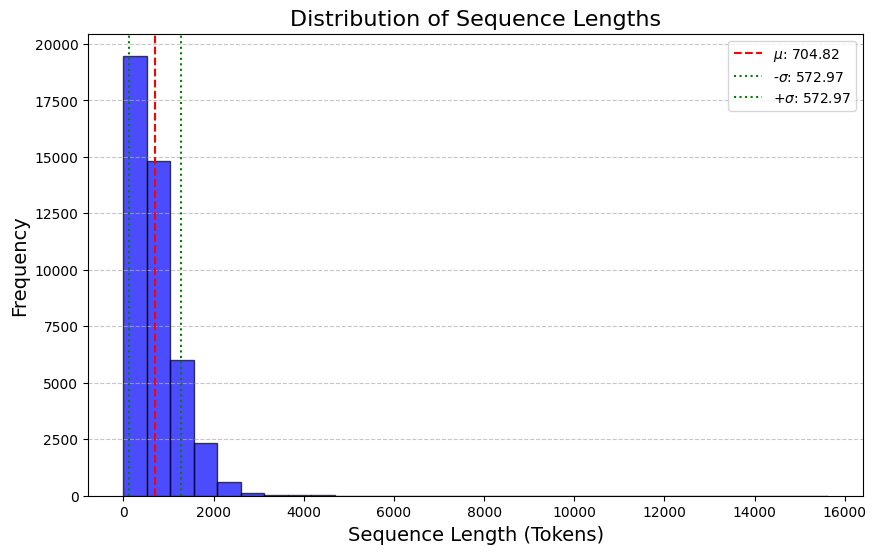

In [13]:
# compute and plot the sequence length statistics
original_seq_length_mean, original_seq_length_std = get_sequence_length_statistics(merged_dataset)

## Retaining Moderate Sequence Lengths

We are targetting small language models. Although latest models show great performances (the context length are quite high), given the limited dataset that we should consider (MAX_SAMPLES=5000 including train test and validation splits) we decide to keep a moderate sequence length for training stability. 

Assuming that a token is 0.75 words on average:

- 30 tokens is roughly 23 words which represents one or two or up to three sentences.
- Similarly, 4096 tokens is roughly 3072 words which is a long article of about 16 pages (assuming 250 words per page).

In [14]:
# Define minimum and maximum sequence lengths. 
min_sequence_length = 30
max_sequence_length = 4096 

# Define k to 3, which is a common value used in statistics ensures minimal outlier removal and data retention of 99.7%
k = 3

# Calculate bounds (ensure no negative lengths)
lower_bound = max(original_seq_length_mean - k * original_seq_length_std, min_sequence_length)
upper_bound = max_sequence_length # one could do original_seq_length_mean + k * original_seq_length_std but we omit it

print(f"Filtering sequences with lengths between {lower_bound:.2f} and {upper_bound:.2f} tokens.")

Filtering sequences with lengths between 30.00 and 4096.00 tokens.


In [15]:
# create a subset of the dataset with sequence lengths within the defined bounds
subset = [
    doc for doc in merged_dataset 
    if lower_bound <= doc["sequence_length"] <= upper_bound
]
print(f'Kept only {len(subset)} out of {len(merged_dataset)} documents.')

Kept only 43289 out of 43449 documents.


New sequence-length range: 30–3895
Average sequence length: 699.64
Minimum sequence length: 30
Maximum sequence length: 3895
Standard deviation: 514.44


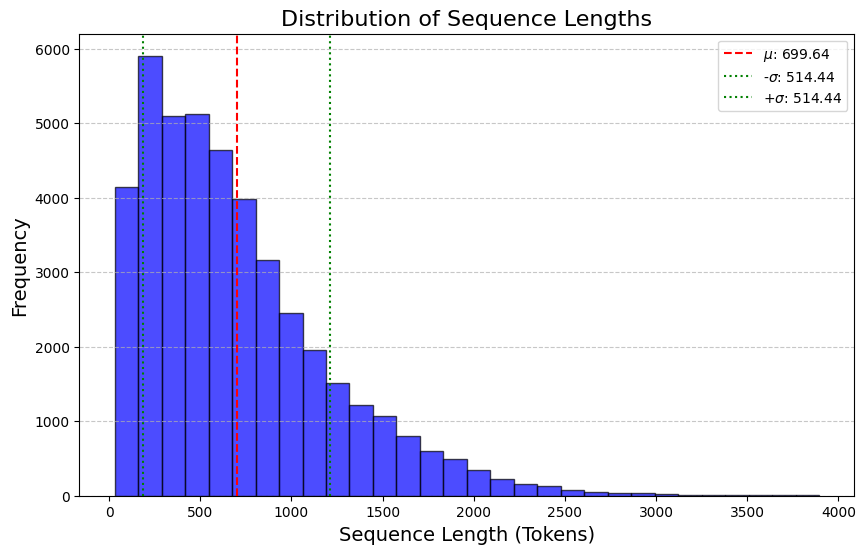

In [16]:
# Extract sequence lengths for analysis
sequence_lengths_filtered = np.array([doc["sequence_length"] for doc in subset])

# compute and plot the new sequence length statistics
print(f"New sequence-length range: {sequence_lengths_filtered.min()}–{sequence_lengths_filtered.max()}")
new_seq_length_mean, new_seq_length_std = get_sequence_length_statistics(subset)

## Data Sampling

Constraint: We want to retain a total of MAX_SAMPLES samples for training, validation and testing

### Uniform sampling

Average sequence length: 710.45
Minimum sequence length: 32
Maximum sequence length: 3870
Standard deviation: 524.90


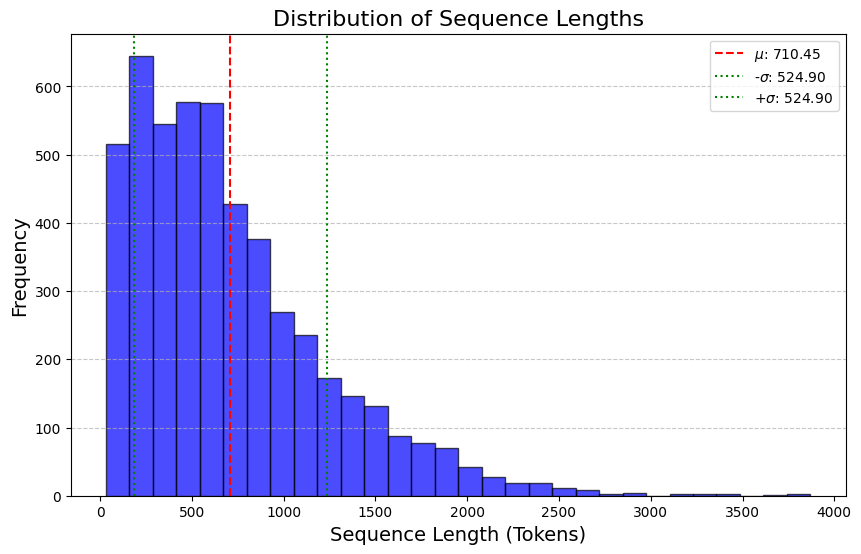

In [17]:
# Sample MAX_SAMPLES documents uniformly (without replacement)
sampled_data_uniform_cuttoff = random.sample(subset, MAX_SAMPLES)

# plot the new sequence length statistics
_, _ = get_sequence_length_statistics(sampled_data_uniform_cuttoff)

In [18]:
merged_dataset

Dataset({
    features: ['text', 'dataset_source', 'sequence_length', 'tokenizer_name'],
    num_rows: 43449
})

#### Nota Bene:
To see the effect of what we've done, we plot the distribution if one does the same sampling strategy, but without doing the cutoff

In [19]:
merged_dataset

Dataset({
    features: ['text', 'dataset_source', 'sequence_length', 'tokenizer_name'],
    num_rows: 43449
})

Average sequence length: 706.75
Minimum sequence length: 1
Maximum sequence length: 13524
Standard deviation: 605.30


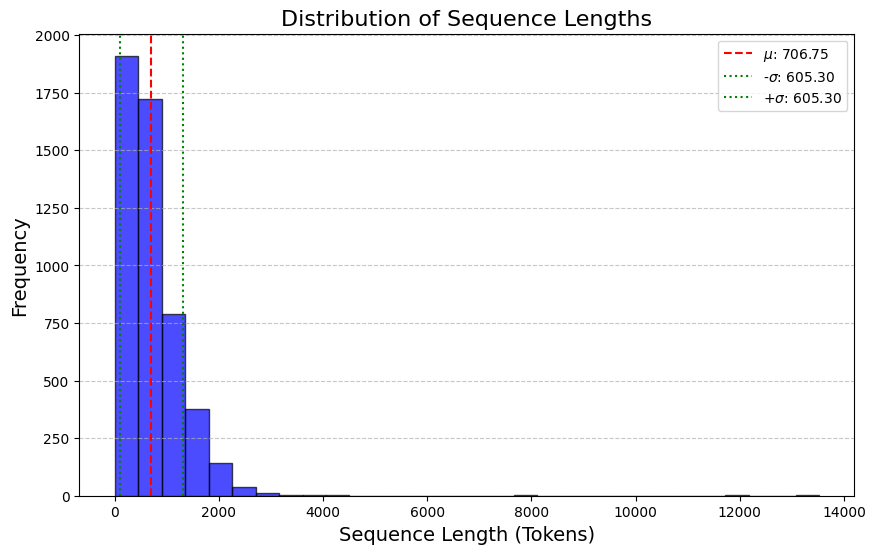

In [20]:
# Sample MAX_SAMPLES documents uniformly (without replacement)
merged_dataset = list(merged_dataset)

sampled_data_merge = random.sample(merged_dataset, MAX_SAMPLES)

# plot the new sequence length statistics
_, _ = get_sequence_length_statistics(sampled_data_merge)

### Reverse Importance sampling

As it can be seen from the plot, the distribution reveals a higher prevalence of sequences with shorter lengths. To address this imbalance, the objective is to sample 5,000 sequences using reverse probabilities, thereby giving greater weight to longer sequences that are less frequent in the dataset.

In [21]:
# Extract sequence lengths
sequence_lengths = [doc["sequence_length"] for doc in subset]

# Create bins
num_bins = 50

# Create a DataFrame for easier manipulation
df = pd.DataFrame({"sequence_length": sequence_lengths})

# Bin the sequence lengths
df["bin"], bins = pd.cut(df["sequence_length"], bins=num_bins, retbins=True)

# Calculate original bin probabilities
bin_counts = df["bin"].value_counts().sort_index()

# Normalize to get probabilities
original_probs = bin_counts / len(df)

epsilon = 1e-8  # Avoid division by zero
# Calculate reverse weights
reverse_weights = 1 / (original_probs + epsilon)

# Normalize the reverse weights
reverse_weights_normalized = reverse_weights / reverse_weights.sum()

# Add weights to the DataFrame
df["weight"] = df["bin"].map(reverse_weights_normalized)

# Sample using the weights
sampled_df = df.sample(n=MAX_SAMPLES, weights="weight", replace=False, random_state=SEED)

# Extract the sampled data
sampled_data_reverse_sampling = [subset[i] for i in sampled_df.index]

Average sequence length: 1223.25
Minimum sequence length: 30
Maximum sequence length: 3895
Standard deviation: 763.46


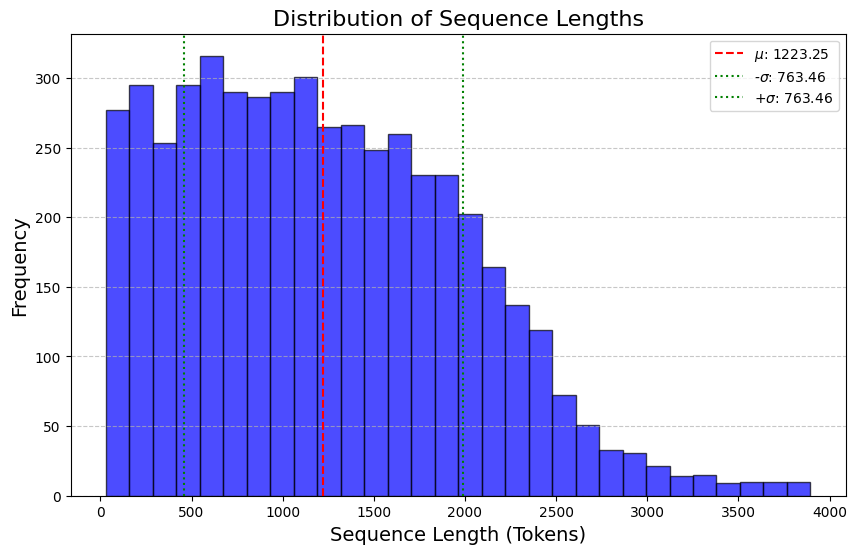

In [22]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(sampled_data_reverse_sampling)

### Nota Bene:
Again, to see the effect of what we've done, we plot the distribution if one does the same sampling strategy, but without doing the cutoff

In [23]:
# Extract sequence lengths
sequence_lengths = [doc["sequence_length"] for doc in merged_dataset]

# Create bins
num_bins = 50

# Create a DataFrame for easier manipulation
df = pd.DataFrame({"sequence_length": sequence_lengths})

# Bin the sequence lengths
df["bin"], bins = pd.cut(df["sequence_length"], bins=num_bins, retbins=True)

# Calculate original bin probabilities
bin_counts = df["bin"].value_counts().sort_index()

# Normalize to get probabilities
original_probs = bin_counts / len(df)

epsilon = 1e-8  # Avoid division by zero
# Calculate reverse weights
reverse_weights = 1 / (original_probs + epsilon)

# Normalize the reverse weights
reverse_weights_normalized = reverse_weights / reverse_weights.sum()

# Add weights to the DataFrame
df["weight"] = df["bin"].map(reverse_weights_normalized)

# Sample using the weights
sampled_df = df.sample(n=MAX_SAMPLES, weights="weight", replace=False, random_state=SEED)

# Extract the sampled data
sampled_data_merge = [merged_dataset[i] for i in sampled_df.index]

Average sequence length: 1268.47
Minimum sequence length: 1
Maximum sequence length: 15624
Standard deviation: 1034.95


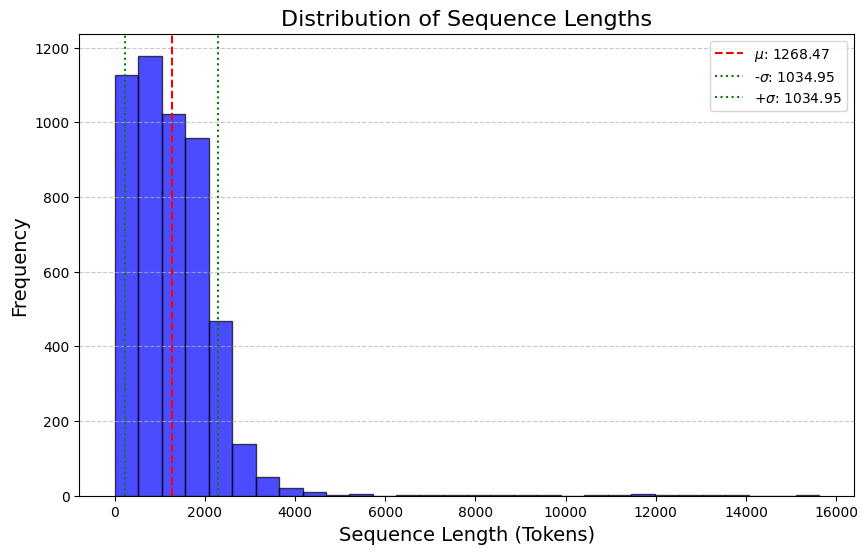

In [24]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(sampled_data_merge)

It is now clear that to ensure the model is exposed to a more uniform distribution of sequence lengths and to enhance its generalization capabilities, the cutoff strategy we implemented can be effectively utilized. 
However, this is only a kind of heuristic to help the model learn better and converge smoother. It remains to be seen whether the model is well-trained and capable of learning effectively.

## Push the dataset to the hub

In [25]:
def create_noncontiguous_splits(data, train_ratio=0.8, val_ratio=0.1, seed=42):
    """
    Creates train/val/test splits with:
    - Random non-contiguous indices
    - No overlapping samples
    - Exact proportional allocation
    - Reproducibility via seed
    """
    # initialize random number generator
    rng = np.random.default_rng(seed)
    
    # Get data length and indices
    n = len(data)
    indices = np.arange(n)
    
    # Compute train/val sizes. We get the test size directly from the two
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    
    # Non-contiguous random selection
    train_indices = rng.choice(indices, train_size, replace=False)
    # Update remaining indices
    remaining = np.setdiff1d(indices, train_indices, assume_unique=True)
    # Validation indices
    val_indices = rng.choice(remaining, val_size, replace=False)
    # The remaining indices are for testing
    test_indices = np.setdiff1d(remaining, val_indices, assume_unique=True)

    # Final verification
    assert len(set(train_indices) & set(val_indices)) == 0, "Overlap detected!"
    assert len(set(train_indices) & set(test_indices)) == 0, "Overlap detected!"
    assert len(set(val_indices) & set(test_indices)) == 0, "Overlap detected!"
    
    return (
        [data[i] for i in train_indices],
        [data[i] for i in val_indices],
        [data[i] for i in test_indices]
    )

In [26]:
df = pd.DataFrame(sampled_data_reverse_sampling)

In [27]:
df.head()

,text,dataset_source,sequence_length,tokenizer_name
0,ستساعدك الصور على سرد القصة التي تريد إخبارها....,Abdelkareem/wikihow-arabic-summarization,891,Qwen/Qwen2.5-7B-Instruct-AWQ
1,في العام 1061 ميلادية كانت صقلية لا تزال جزيرة...,Abdelkareem/arabic-article-summarization,1748,Qwen/Qwen2.5-7B-Instruct-AWQ
2,اتفقت الشركة القطرية لتموين الطائرات الحكومية ...,Abdelkareem/arabic-article-summarization,417,Qwen/Qwen2.5-7B-Instruct-AWQ
3,يقف أحد الضاربين في إحدى نهايات الملعب والآخر ...,Abdelkareem/wikihow-arabic-summarization,2135,Qwen/Qwen2.5-7B-Instruct-AWQ
4,إذا كنت تعاني من التهابات اللسان ولم تفلح الأد...,Abdelkareem/wikihow-arabic-summarization,1101,Qwen/Qwen2.5-7B-Instruct-AWQ


In [28]:
# Create the train/validation/test splits. Here we set the seed to 1 as it is the one that gives a good balance of sequence length distribution between the validation and test splits.
train_data, val_data, test_data = create_noncontiguous_splits(sampled_data_reverse_sampling, train_ratio=TRAIN_RATIO, val_ratio=VALIDATION_RATIO, seed=1) 

# Verification
print(f"Original size: {len(sampled_data_reverse_sampling)}")
print(f"Train: {len(train_data)} ({len(train_data)/len(sampled_data_reverse_sampling):.1%})")
print(f"Validation: {len(val_data)} ({len(val_data)/len(sampled_data_reverse_sampling):.1%})")
print(f"Test: {len(test_data)} ({len(test_data)/len(sampled_data_reverse_sampling):.1%})")

Original size: 5000
Train: 4000 (80.0%)
Validation: 500 (10.0%)
Test: 500 (10.0%)


Average sequence length: 1224.48
Minimum sequence length: 30
Maximum sequence length: 3895
Standard deviation: 765.61


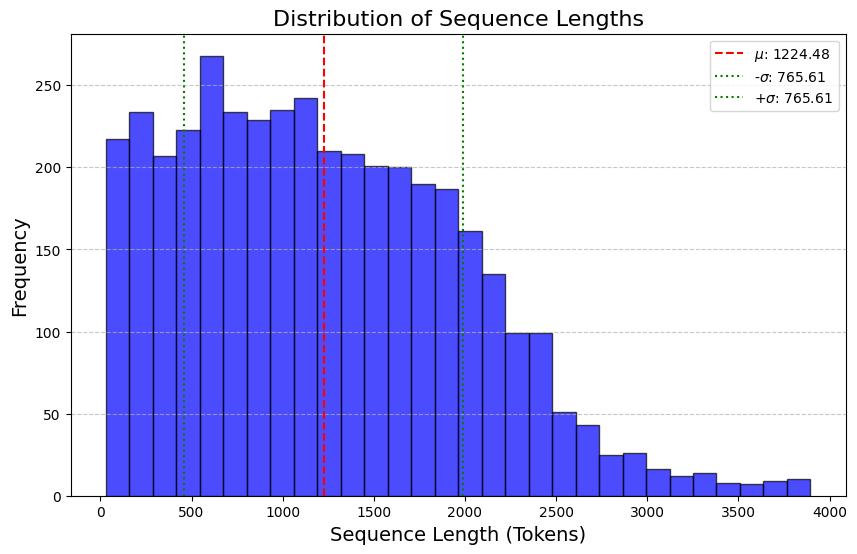

In [29]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(train_data)

Average sequence length: 1233.40
Minimum sequence length: 61
Maximum sequence length: 3676
Standard deviation: 705.79


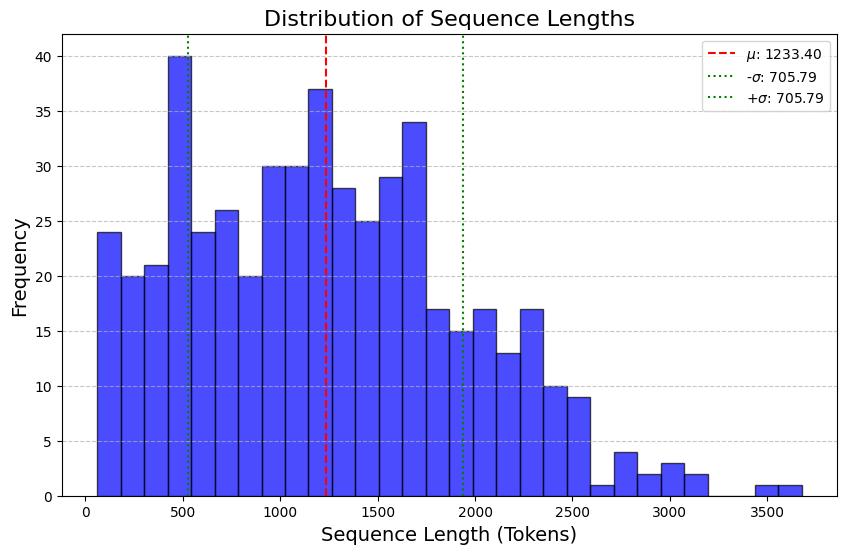

In [30]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(val_data)

Average sequence length: 1203.31
Minimum sequence length: 45
Maximum sequence length: 3580
Standard deviation: 800.53


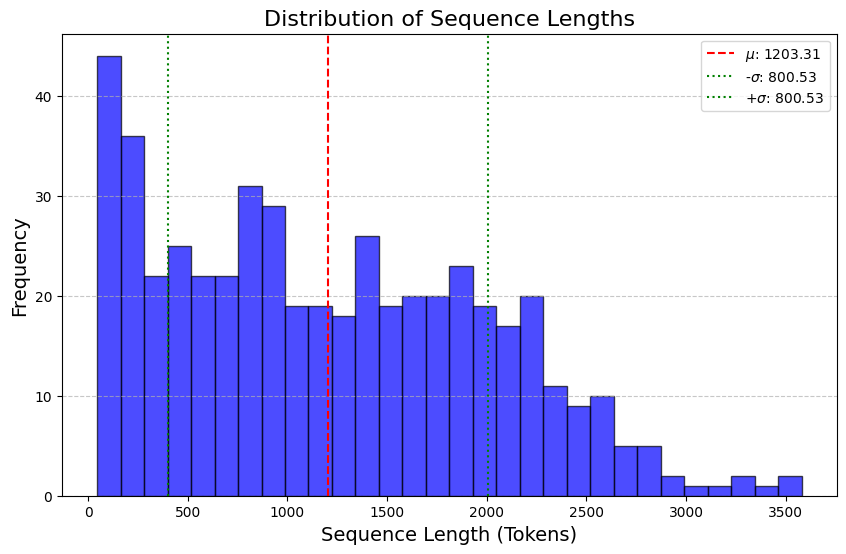

In [31]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(test_data)

In [32]:
final_dataset = DatasetDict({
    "train": Dataset.from_pandas(pd.DataFrame(train_data)),
    "validation": Dataset.from_pandas(pd.DataFrame(val_data)),
    "test": Dataset.from_pandas(pd.DataFrame(test_data))
})

In [33]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'dataset_source', 'sequence_length', 'tokenizer_name'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['text', 'dataset_source', 'sequence_length', 'tokenizer_name'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'dataset_source', 'sequence_length', 'tokenizer_name'],
        num_rows: 500
    })
})

In [34]:
final_dataset.push_to_hub("BounharAbdelaziz/Arabic-Summarization-Splits", private=True, commit_message="Sampled the Train, Validation and Test splits")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/BounharAbdelaziz/Arabic-Summarization-Splits/commit/5c38cc831573bec259e2e87bc90925115b8a4fb2', commit_message='Sampled the Train, Validation and Test splits', commit_description='', oid='5c38cc831573bec259e2e87bc90925115b8a4fb2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BounharAbdelaziz/Arabic-Summarization-Splits', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BounharAbdelaziz/Arabic-Summarization-Splits'), pr_revision=None, pr_num=None)

# Clean the Synthetic Dataset from Chinese Samples if any

In [2]:
import re

def contains_chinese_characters(sentence):
    """
    Check if a sentence contains Chinese characters.

    Args:
        sentence (str): The input sentence to check.

    Returns:
        bool: True if the sentence contains Chinese characters, False otherwise.
    """
    # Define the Unicode range for Chinese characters
    chinese_char_regex = re.compile(r'[\u4e00-\u9fff]')  # Covers most Chinese characters
    return bool(chinese_char_regex.search(sentence))

In [6]:
# Test cases
sentences = [
    # Contains Chinese characters
    "أ勹",  
    # No Chinese characters
    "يحتوي عصير الليمون على حمض الستريك لتفتيح النمش، ويستخدم مرتين أسبوعيا. يجعل البشرة حساسية لأشعة الشمس، لذا اغسليه بعد استخدامه. يمكن خفض قوته بالماء أو ماء الورد لبشرة حساسة. حليب الزبدة يفتح البشرة باستخدام حمض اللبنيك، يستخدم مرتين يوميا. خليط حليب الزبدة وعصير الليمون مفيد لبشرة دهنية جدا. خلطة العسل والزبادي تساعد في تقليل النمش، يستخدم مرتين يوميا. خل التفاح يعالج النمش، يستخدم مرة يوميا لتجنب التجفيف. خلطة خل التفاح وعصير البصل تساعد في علاج النمش. الصبار يعالج النمش، يستخدم بدون شطف. زيت الخروع مقشر للبشرة، يستخدم مرتين يوميا. خليط زيت الخروع وزيوت أخرى يساعد في البشرة الجافة. خشب الصندل يساعد في تخفيف النمش، يستخدم كمعجون أو زيت عطري.",  
    # Contains Chinese characters
    "确保休息，避免过度运动。保持背部放松的姿势，使用枕头支撑。适量饮水，平衡饮食。",  
    # contains Chinese characters
    "إذا تيقظت بسبب تقلصات الظهر، ابق مستيقظا قليلا وقم بتمارين الاسترخاء. إذا كانت الحركة صعبة، حاول أن تستلق على ظهرك ثم تقلب على جنبك مع ثني الركبتين. ركض رجليك قليلا ثم استخدم يديك لدفع نفسك. لإطالة الظهر، لمس أصابع القدم أو الجلوس وإطالة الرجلين مع الانحناء. المشي الخفيف وليوجا الخفيفة مفيدان. التدليك والحرارة والثلج قد يساعدون. تمارين التنفس العميق والراحة المريحة也能缓解症状。确保休息，避免过度运动。保持背部放松的姿势，使用枕头支撑。适量饮水，平衡饮食。",  
]

for sentence in sentences:
    print(f"{contains_chinese_characters(sentence)}")

True
False
True
True


In [12]:
train_dataset = load_dataset("BounharAbdelaziz/Arabic-Synthetic-Summarization-Dataset", split="train")
eval_dataset = load_dataset("BounharAbdelaziz/Arabic-Synthetic-Summarization-Dataset", split="validation")
test_dataset = load_dataset("BounharAbdelaziz/Arabic-Synthetic-Summarization-Dataset", split="test")

In [13]:
train_dataset = train_dataset.filter(lambda row: not contains_chinese_characters(row['summary']))
eval_dataset = eval_dataset.filter(lambda row: not contains_chinese_characters(row['summary']))
test_dataset = test_dataset.filter(lambda row: not contains_chinese_characters(row['summary']))

In [14]:
filtered_dataset = DatasetDict({
    "train": train_dataset,
    "validation": eval_dataset,
    "test": test_dataset,
})

In [15]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'summary_model_name', 'tokenizer_name', 'dataset_source', 'sequence_length'],
        num_rows: 3526
    })
    validation: Dataset({
        features: ['text', 'summary', 'summary_model_name', 'tokenizer_name', 'dataset_source', 'sequence_length'],
        num_rows: 437
    })
    test: Dataset({
        features: ['text', 'summary', 'summary_model_name', 'tokenizer_name', 'dataset_source', 'sequence_length'],
        num_rows: 444
    })
})

We can see that there was quite some samples (exactly 593) containing chineese characters. This is a typical behavior of Qwen models that switch to chineese sometimes. 
The intuition behind such behavior is that a token/character in chineese contains more information than english or arabic tokens.

In [16]:
filtered_dataset.push_to_hub("BounharAbdelaziz/Arabic-Synthetic-Summarization-Dataset-Filtered", private=True, commit_message="Filtered out samples containing chineese in summary.")

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/BounharAbdelaziz/Arabic-Synthetic-Summarization-Dataset-Filtered/commit/cd09bab081b0311cb9604a67892816bd32cea3f8', commit_message='Filtered out samples containing chineese in summary.', commit_description='', oid='cd09bab081b0311cb9604a67892816bd32cea3f8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BounharAbdelaziz/Arabic-Synthetic-Summarization-Dataset-Filtered', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BounharAbdelaziz/Arabic-Synthetic-Summarization-Dataset-Filtered'), pr_revision=None, pr_num=None)

### Check again the statistics

Average sequence length: 1222.66
Minimum sequence length: 30
Maximum sequence length: 3895
Standard deviation: 763.56


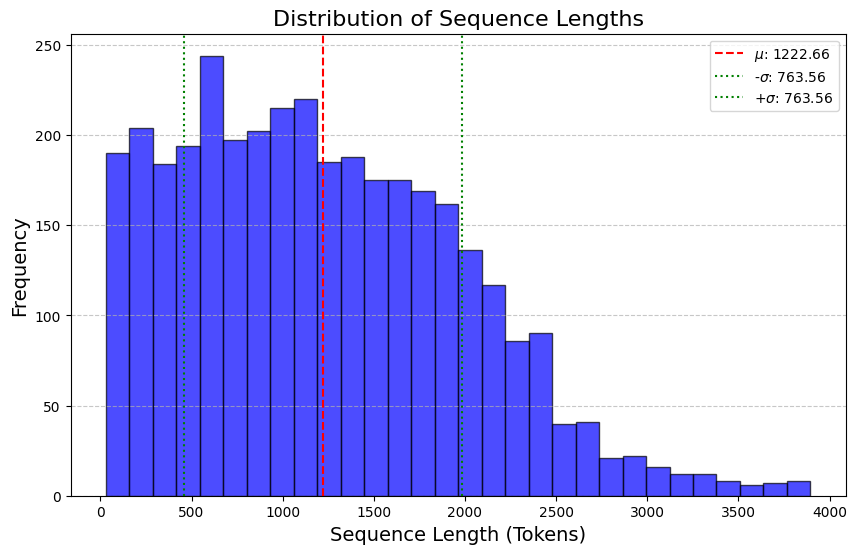

In [20]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(train_dataset)

Average sequence length: 1229.14
Minimum sequence length: 64
Maximum sequence length: 3676
Standard deviation: 704.71


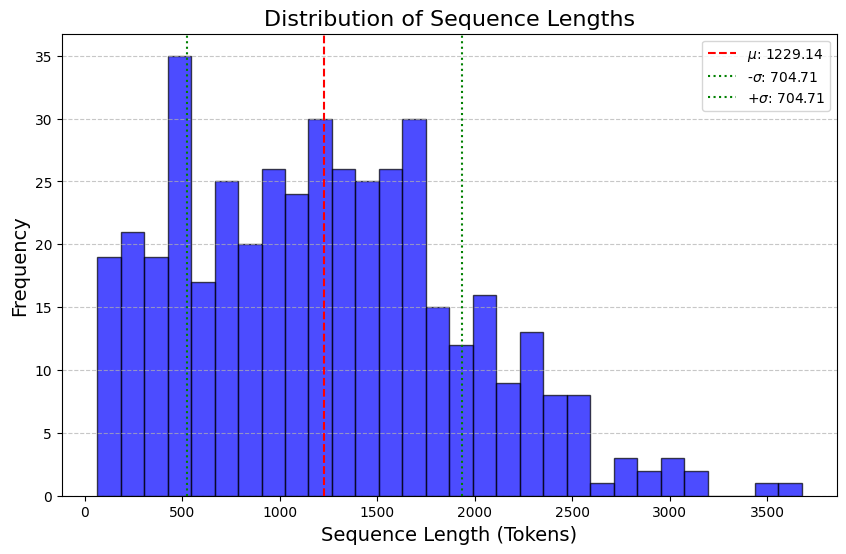

In [23]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(eval_dataset)

Average sequence length: 1207.10
Minimum sequence length: 45
Maximum sequence length: 3580
Standard deviation: 801.52


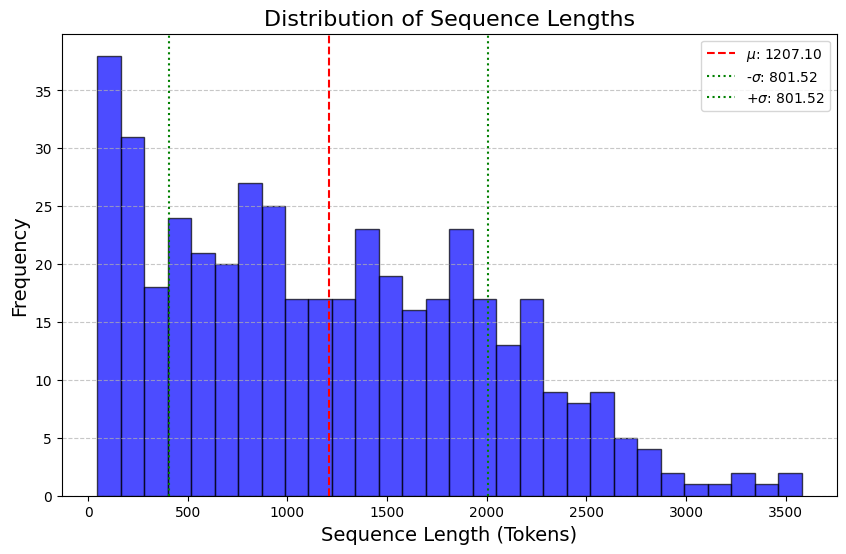

In [24]:
# plot the new sequence length statistics
_, _ =get_sequence_length_statistics(test_dataset)